# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

import phik
from phik.report import plot_correlation_matrix

from tqdm import tqdm

from IPython.display import display

from catboost import CatBoostRegressor
from catboost import cv, Pool

In [4]:
# Прочитаем, взглянем на первые 3 строки.
data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

# Сохраним без изменений
data_origin = data.copy()
data.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


**Признаки:**
* DateCrawled — дата скачивания анкеты из базы;
* VehicleType — тип автомобильного кузова;
* RegistrationYear — год регистрации автомобиля;
* Gearbox — тип коробки передач;
* Power — мощность (л. с.);
* Model — модель автомобиля;
* Kilometer — пробег (км);
* RegistrationMonth — месяц регистрации автомобиля;
* FuelType — тип топлива;
* Brand — марка автомобиля;
* NotRepaired — была машина в ремонте или нет;
* DateCreated — дата создания анкеты;
* NumberOfPictures — количество фотографий автомобиля;
* PostalCode — почтовый индекс владельца анкеты (пользователя);
* LastSeen — дата последней активности пользователя.

**Целевой признак:**
* Price — цена (евро).

Посмотрим `info()`

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
data.isna().mean()[data.isna().mean() > 0]

VehicleType    0.105794
Gearbox        0.055967
Model          0.055606
FuelType       0.092827
NotRepaired    0.200791
dtype: float64

Есть пропуски. Проверим каждый столбец на тип данных, пропуски, изучим сами данные.

### Анализ столбцов

Для начала приведем к единому регистру названия столбцов.

In [7]:
# функция для преобразования названий столбцов из CamelCase в snake_case
def camel_to_snake(data):
    col = []
    for row in data.columns:
        index = [i for i, c in enumerate(row) if c.isupper()]
        count = -1
        for i in index:
            if i != 0:
                count += 1
                row = row[:i+count] + '_' + row[i+count:]
        col.append(row.lower())
    return col
    

In [8]:
data.columns = camel_to_snake(data)

In [9]:
# Проверка
data.head(3)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


#### date_crawled

In [10]:
# проверим тип данных
data['date_crawled'].dtype

dtype('O')

In [11]:
# переведем во временной формат
data['date_crawled'] = pd.to_datetime(
    data['date_crawled'], format='%Y.%m.%d %H:%M:%S')

data['date_crawled'].head(3)

0   2016-03-24 11:52:17
1   2016-03-24 10:58:45
2   2016-03-14 12:52:21
Name: date_crawled, dtype: datetime64[ns]

In [12]:
# посмотрим сколько не уникальных значений
data['date_crawled'].value_counts().loc[
    (data['date_crawled'].value_counts() > 1)
    ].shape

(76431,)

Много значений, проверим датафрейм на дубликаты.

In [13]:
data.duplicated().sum()

4

In [14]:
# поглядим
data[data.duplicated()]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Явно не дубликаты... Посмотрим по дублирующей дате.

In [15]:
(
    data['date_crawled'].value_counts()
    .loc[(data['date_crawled'].value_counts() > 6)].index[0]
)

Timestamp('2016-03-24 14:49:47')

In [16]:
data[
    data['date_crawled'] == 
    data['date_crawled'].value_counts()
    .loc[(data['date_crawled'].value_counts() > 6)].index[0]
    ]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
33696,2016-03-24 14:49:47,3799,sedan,2002,manual,101,a4,150000,10,gasoline,audi,yes,2016-03-24 00:00:00,0,72800,2016-04-07 06:45:17
41468,2016-03-24 14:49:47,990,wagon,2000,manual,0,passat,150000,3,gasoline,volkswagen,NaN,2016-03-24 00:00:00,0,83646,2016-04-01 23:41:53
43209,2016-03-24 14:49:47,3000,sedan,2004,manual,116,3er,150000,1,gasoline,bmw,no,2016-03-24 00:00:00,0,78467,2016-04-07 06:45:18
72521,2016-03-24 14:49:47,4800,small,1982,manual,34,kaefer,70000,12,petrol,volkswagen,no,2016-03-24 00:00:00,0,14947,2016-04-07 06:45:17
131819,2016-03-24 14:49:47,850,convertible,1992,manual,198,80,150000,5,petrol,audi,yes,2016-03-24 00:00:00,0,90443,2016-03-30 16:15:57
150172,2016-03-24 14:49:47,399,small,1999,manual,0,NaN,150000,0,petrol,lancia,yes,2016-03-24 00:00:00,0,89231,2016-04-07 06:45:19
218110,2016-03-24 14:49:47,7500,sedan,2002,auto,309,e_klasse,150000,11,petrol,mercedes_benz,no,2016-03-24 00:00:00,0,50321,2016-03-27 11:44:58


Аномалий нет. Посмотрим пропуски.

In [17]:
# Пропусков нет
data['date_crawled'].isna().mean()

0.0

In [18]:
# Аномалий нет
data['date_crawled'].describe(datetime_is_numeric=True)

count                           354369
mean     2016-03-21 12:58:10.450648320
min                2016-03-05 14:06:22
25%                2016-03-13 11:52:33
50%                2016-03-21 17:50:55
75%                2016-03-29 14:37:20
max                2016-04-07 14:36:58
Name: date_crawled, dtype: object

#### price

In [19]:
# Пропусков нет
data['price'].isna().mean()

0.0

In [20]:
data['price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

Пропусков нет, но есть нули. Исследуем.

In [21]:
# Количество значений, где цена на авто ниже 100 долларов
len(data[data['price'] < 100])

13314

In [22]:
# Взглянем на эти значения
data[data['price'] < 100].head(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29 00:00:00,0,53721,2016-04-06 01:44:38
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28 00:00:00,0,40589,2016-04-06 12:15:54
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10
154,2016-03-22 16:37:59,0,NaN,2006,NaN,0,other,5000,0,NaN,fiat,NaN,2016-03-22 00:00:00,0,44867,2016-04-06 06:17:56
231,2016-03-16 22:06:24,0,wagon,2001,manual,115,mondeo,150000,0,NaN,ford,NaN,2016-03-16 00:00:00,0,57627,2016-03-26 11:17:50
268,2016-03-12 07:26:49,1,sedan,1990,manual,90,80,70000,6,petrol,audi,no,2016-03-11 00:00:00,0,55122,2016-03-26 23:15:49


In [23]:
data[data['price'] < 100]['price'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 24, 25, 26, 27, 29, 30, 32, 33, 35, 38, 39, 40, 45,
       47, 49, 50, 55, 58, 59, 60, 65, 66, 69, 70, 74, 75, 77, 79, 80, 85,
       88, 89, 90, 95, 98, 99], dtype=int64)

In [24]:
data[data['price'] < 100]['registration_year'].sort_values().unique()

array([1000, 1111, 1200, 1253, 1500, 1688, 1800, 1910, 1915, 1919, 1920,
       1929, 1930, 1933, 1934, 1935, 1937, 1942, 1948, 1950, 1951, 1952,
       1954, 1955, 1956, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2222,
       2500, 2800, 3000, 3500, 5000, 6500, 7500, 8000, 8455, 9000, 9229,
       9996, 9999], dtype=int64)

In [25]:
data[data['price'] > 100]['registration_year'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1234, 1300, 1400, 1500, 1600, 1602, 1800,
       1910, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934,
       1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946,
       1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2290, 2500,
       2800, 2900, 3000, 3200, 3700, 3800, 4000, 4100, 4500, 4800, 5000,
       5300, 5555, 5600, 5900, 5911, 6000, 7000, 7100, 7800, 8200, 8500,
       8888, 9000, 9450, 9999], dtype=int64)

Много аномалий по цене. При просмотре зависимости от года выявились аномалии и в годах регистрации.

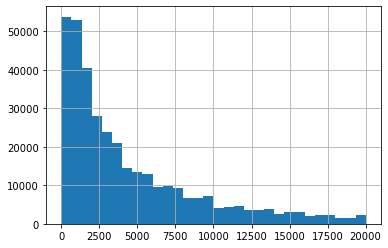

In [26]:
# Посмотрим гистограмму по цене
data['price'].hist(bins=30);

In [27]:
data[data['price'] > 17500].head(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
14,2016-03-21 12:57:01,17999,suv,2011,manual,190,navara,70000,3,gasoline,nissan,no,2016-03-21 00:00:00,0,4177,2016-04-06 07:45:42
33,2016-03-25 21:48:47,18000,sedan,2007,auto,218,3er,20000,5,petrol,bmw,no,2016-03-25 00:00:00,0,39179,2016-04-07 04:45:21
172,2016-03-07 12:38:19,19750,convertible,2006,manual,305,mustang,50000,7,petrol,ford,no,2016-03-07 00:00:00,0,38350,2016-03-12 20:18:29
204,2016-03-31 12:58:26,18400,wagon,2011,auto,313,5er,150000,11,gasoline,bmw,no,2016-03-31 00:00:00,0,52477,2016-03-31 13:44:44
282,2016-03-06 12:38:13,18700,coupe,2009,auto,213,mustang,80000,8,petrol,ford,no,2016-03-06 00:00:00,0,97424,2016-04-06 05:44:39
337,2016-03-20 11:44:15,18880,bus,2014,manual,116,5_reihe,20000,11,gasoline,mazda,no,2016-03-20 00:00:00,0,59872,2016-04-06 08:46:43
484,2016-03-31 23:52:32,19900,bus,2009,manual,150,viano,90000,5,gasoline,mercedes_benz,no,2016-03-31 00:00:00,0,59348,2016-04-07 03:17:20
521,2016-03-14 22:57:33,18300,suv,2013,manual,122,tiguan,40000,1,petrol,volkswagen,no,2016-03-14 00:00:00,0,92685,2016-04-07 05:46:14
742,2016-04-03 16:58:42,18000,convertible,2012,manual,122,golf,20000,6,petrol,volkswagen,no,2016-04-03 00:00:00,0,49124,2016-04-05 16:46:42


In [28]:
data[data['price'] > 17500]['brand'].unique()

array(['audi', 'nissan', 'bmw', 'ford', 'mazda', 'mercedes_benz',
       'volkswagen', 'skoda', 'peugeot', 'smart', 'seat', 'subaru',
       'porsche', 'hyundai', 'toyota', 'kia', 'sonstige_autos', 'mini',
       'opel', 'saab', 'mitsubishi', 'jeep', 'chevrolet', 'fiat', 'dacia',
       'alfa_romeo', 'jaguar', 'renault', 'volvo', 'citroen', 'chrysler',
       'honda', 'land_rover', 'suzuki', 'lancia'], dtype=object)

В общем и целом верхний потолок цен не выглядит аномальным. Изучим низкие цены.

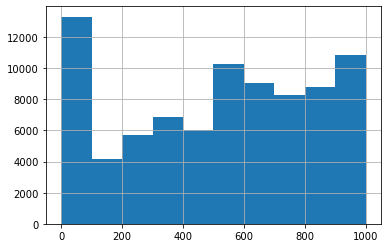

In [29]:
data[data['price'] < 1000]['price'].hist();

In [30]:
data[
    (data['price'] > 200) & (data['price'] < 300)
    ]['registration_year'].sort_values().unique()

array([1234, 1910, 1960, 1965, 1969, 1970, 1974, 1975, 1977, 1980, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 4000, 5000], dtype=int64)

Логично будет при подготовке выборки для модели сначала обработать аномалии в остальных признаках, а цену в последнюю очередь. Пока держим в уме наши заключения и исследуем дальше.

#### vehicle_type

In [31]:
data['vehicle_type'].isna().mean()

0.1057936783409384

Есть пропуски ~10%.

In [32]:
data['vehicle_type'].sort_values().unique()

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)

In [33]:
data[(data['vehicle_type']== 'sedan') & (data['model'] == 'golf')].head(5)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0,44145,2016-03-17 18:17:43
58,2016-03-31 08:57:44,1000,sedan,1998,manual,101,golf,150000,10,petrol,volkswagen,no,2016-03-31 00:00:00,0,39624,2016-04-06 03:15:47
74,2016-03-31 18:46:36,6600,sedan,2006,manual,105,golf,150000,10,gasoline,volkswagen,no,2016-03-31 00:00:00,0,41812,2016-03-31 18:46:36
113,2016-03-20 18:38:02,6300,sedan,2002,manual,265,golf,150000,3,petrol,volkswagen,no,2016-03-20 00:00:00,0,56759,2016-04-07 01:45:06
124,2016-03-18 23:41:18,1000,sedan,1990,manual,54,golf,150000,2,petrol,volkswagen,no,2016-03-18 00:00:00,0,47447,2016-04-05 23:16:13


In [34]:
data[data['vehicle_type'].isna() == True].head(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46
31,2016-03-29 16:57:02,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29 00:00:00,0,37075,2016-03-29 17:43:07
35,2016-03-08 07:54:46,350,NaN,2016,manual,75,golf,150000,4,petrol,volkswagen,no,2016-03-08 00:00:00,0,19386,2016-03-08 09:44:50
37,2016-03-28 17:50:15,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25 00:00:00,0,48499,2016-03-31 21:47:44
51,2016-03-07 18:57:08,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07 00:00:00,0,66115,2016-03-07 18:57:08


Попробуем заполнить через столбец `model`.

In [35]:
# Количество пропусков модели `golf`
len(data[
    (data['vehicle_type'].isna() == True) & (data['model'] == 'golf')
    ])

4035

In [36]:
# Изучим класс `small`
data[data['vehicle_type'] == 'small'].head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
17,2016-03-20 10:25:19,1750,small,2004,auto,75,twingo,150000,2,petrol,renault,no,2016-03-20 00:00:00,0,65599,2016-04-06 13:16:07


Видим опять `golf`. Значит можно заполнить часть пропусков. Вообще максимально странно выглядят данные пропуски. Попоробуем решить задачу с помощью поиска класса автомобиля через модель.

In [37]:
# Все модели с NaN в `vehicle_type`
t = (
    data[data['vehicle_type'].isna() == True]['model']
    .sort_values().unique().tolist()
)
# Удалим NaN из списка
t.pop()

nan

In [38]:
# Проверка, что нет NaN
display(t[-5:])
display(len(t))

['yaris', 'yeti', 'ypsilon', 'z_reihe', 'zafira']

241

In [39]:
# Проверим наоборот по гольфу, где нет пропусков в `vehicle_type`
data[
    (data['vehicle_type'].isna() != True) & (data['model'] == 'golf')
    ].head(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0,44145,2016-03-17 18:17:43
58,2016-03-31 08:57:44,1000,sedan,1998,manual,101,golf,150000,10,petrol,volkswagen,no,2016-03-31 00:00:00,0,39624,2016-04-06 03:15:47
74,2016-03-31 18:46:36,6600,sedan,2006,manual,105,golf,150000,10,gasoline,volkswagen,no,2016-03-31 00:00:00,0,41812,2016-03-31 18:46:36
113,2016-03-20 18:38:02,6300,sedan,2002,manual,265,golf,150000,3,petrol,volkswagen,no,2016-03-20 00:00:00,0,56759,2016-04-07 01:45:06
124,2016-03-18 23:41:18,1000,sedan,1990,manual,54,golf,150000,2,petrol,volkswagen,no,2016-03-18 00:00:00,0,47447,2016-04-05 23:16:13
136,2016-04-03 15:58:09,4300,sedan,2005,manual,90,golf,150000,11,gasoline,volkswagen,NaN,2016-04-03 00:00:00,0,28779,2016-04-05 15:46:23
146,2016-03-27 12:59:00,1000,small,1996,manual,75,golf,150000,3,petrol,volkswagen,no,2016-03-27 00:00:00,0,38640,2016-04-01 12:45:50
158,2016-04-01 16:06:24,800,sedan,1993,manual,0,golf,10000,9,petrol,volkswagen,yes,2016-04-01 00:00:00,0,65929,2016-04-07 11:17:07


Не учли, что одна и та же модель может быть и седаном и хетчбеком. Значит пропуски заполнить по какой-либо взаимосвязи не сможем. Запоним как `unknown`.

In [40]:
# Проверка
data['vehicle_type'] = data['vehicle_type'].fillna(value='unknown')
data['vehicle_type'].sort_values().unique()

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'unknown', 'wagon'], dtype=object)

#### gearbox

In [41]:
data['gearbox'].sort_values().unique()

array(['auto', 'manual', nan], dtype=object)

Заполнить пропуски никак не можем. Никакой взаимосвязи с другими столбцами.

In [42]:
# Заполним NaN на `unknown`.
data['gearbox'] = data['gearbox'].fillna(value='unknown')
data['gearbox'].sort_values().unique()

array(['auto', 'manual', 'unknown'], dtype=object)

In [43]:
# Проверка
data['gearbox'].isna().mean()

0.0

#### power

In [44]:
data['power'].isna().mean()

0.0

In [45]:
data['power'].describe()

count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

Мощность 20000...

In [46]:
data[data['power'] > 600].head(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
1816,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,2016-03-22 00:00:00,0,22043,2016-03-22 21:43:26
2102,2016-03-21 11:55:22,0,sedan,1999,unknown,1799,vectra,150000,1,petrol,opel,yes,2016-03-21 00:00:00,0,1723,2016-04-04 04:49:06
3746,2016-03-21 14:48:31,0,unknown,2017,manual,750,NaN,150000,8,petrol,smart,no,2016-03-21 00:00:00,0,49356,2016-03-24 03:44:59
4060,2016-04-03 20:31:00,3100,sedan,2005,manual,953,colt,150000,4,gasoline,mitsubishi,no,2016-04-03 00:00:00,0,60326,2016-04-07 14:56:46
5328,2016-03-29 19:44:48,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,NaN,2016-03-29 00:00:00,0,33154,2016-04-06 05:44:36
6296,2016-03-31 23:50:47,599,small,2002,manual,603,matiz,5000,11,petrol,chevrolet,yes,2016-03-31 00:00:00,0,44379,2016-04-01 03:41:52
6504,2016-03-14 15:54:34,3000,small,2009,manual,771,punto,125000,0,petrol,fiat,NaN,2016-03-14 00:00:00,0,40721,2016-03-14 15:54:34
6637,2016-03-31 19:48:22,600,small,1996,manual,603,corsa,150000,8,petrol,opel,yes,2016-03-31 00:00:00,0,70327,2016-04-06 14:17:51
7661,2016-04-02 19:25:25,1499,small,1999,manual,7515,lupo,150000,4,petrol,volkswagen,NaN,2016-04-02 00:00:00,0,65830,2016-04-06 11:46:49
7720,2016-04-02 11:48:54,1500,small,2000,manual,1400,NaN,150000,0,petrol,honda,NaN,2016-04-02 00:00:00,0,21509,2016-04-04 09:15:26


In [47]:
len(data[data['power'] > 600])

384

In [48]:
data[data['power'] > 600]['price'].describe()

count      384.000000
mean      2946.791667
std       3471.159656
min          0.000000
25%        650.000000
50%       1600.000000
75%       3762.250000
max      18550.000000
Name: price, dtype: float64

При мощности более 600 сил выводятся такие как матиз, пунто и т.д. По идее можно исправить, заполнить. Но из-за 384 строки при полном датасете в 354тыс проще будет удалить. 


Также есть нулевая мощность. Пока оставим как есть.

#### model

In [49]:
# Количество уникальных моделей
len(data['model'].unique())

251

In [50]:
# Пропуски
data['model'].isna().mean()

0.055605879746817584

In [51]:
# Заполним на `unknown`.
data['model'] = data['model'].fillna(value='unknown')
display(data['model'].isna().mean())


0.0

#### kilometer

In [52]:
data['kilometer'].isna().mean()

0.0

In [53]:
data['kilometer'].describe()

count    354369.000000
mean     128211.172535
std       37905.341530
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

Очень странно, что более 50% значений ровно 150000. Будем считать, что сервис просто ограничил пробег для заполнения.

In [54]:
data.head(3)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


#### registration_month	

In [55]:
data['registration_month'].isna().mean()

0.0

In [56]:
data['registration_month'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [57]:
len(data[data['registration_month'] == 0])

37352

Аномалия: нулевой месяц регистрации. Число строк 37352. Пока оставим как есть.

#### fuel_type

In [58]:
data['fuel_type'].isna().mean()

0.09282696849893755

In [59]:
data['fuel_type'].sort_values().unique()

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       nan], dtype=object)

In [60]:
# Заполним на `unknown`. Все аналогично
data['fuel_type'] = data['fuel_type'].fillna(value='unknown')
display(data['fuel_type'].isna().mean())

0.0

In [61]:
data['fuel_type'].sort_values().unique()

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       'unknown'], dtype=object)

#### brand

In [62]:
data['brand'].isna().mean()

0.0

In [63]:
data['brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

Хоть тут все более менее.

#### not_repaired

In [64]:
data['not_repaired'].isna().mean()

0.20079070121822168

In [65]:
data['not_repaired'].sort_values().unique()

array(['no', 'yes', nan], dtype=object)

<AxesSubplot:>

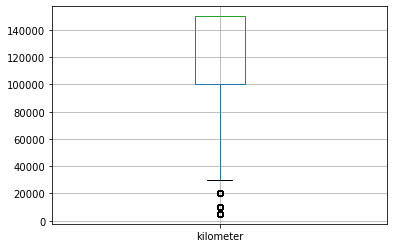

In [66]:
data[data['not_repaired'] == 'no'].boxplot(column='kilometer')

<AxesSubplot:>

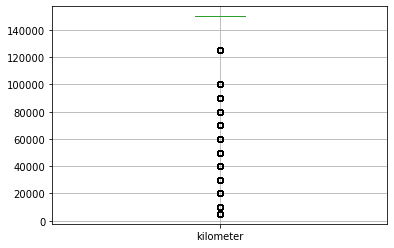

In [67]:
data[data['not_repaired'] == 'yes'].boxplot(column='kilometer')

<AxesSubplot:>

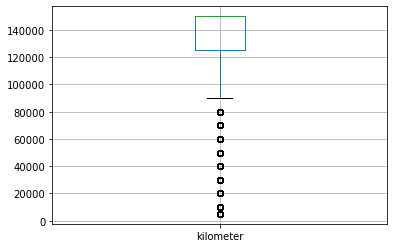

In [68]:
data[data['not_repaired'].isna()].boxplot(column='kilometer')

Будем считать, что если клиент не указал, значит не было ремонта.

In [69]:
data['not_repaired'] = data['not_repaired'].fillna(value='no')
data['not_repaired'].isna().mean()

0.0

In [70]:
# Проверка
data['not_repaired'].value_counts()

no     318315
yes     36054
Name: not_repaired, dtype: int64

Последние 4 столбца, никакой роли в построении модели играть не будут. Удалим. Также первый столбец — дата скачивания анкеты из базы.

In [71]:
data = data.loc[:, 'price':'not_repaired']
data.head(3)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,no
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no


In [72]:
data.isna().mean()

price                 0.0
vehicle_type          0.0
registration_year     0.0
gearbox               0.0
power                 0.0
model                 0.0
kilometer             0.0
registration_month    0.0
fuel_type             0.0
brand                 0.0
not_repaired          0.0
dtype: float64

#### Вывод

1. Привели названия столбцов из CamelCase в snake_case;
2. Обнаружили пропуски в столбцах:
    * VehicleType    0.105794
    * Gearbox        0.055967
    * Model          0.055606
    * FuelType       0.092827
    * NotRepaired    0.200791
3. Пропуски заполнили значением `unknown`, поскольку определить/заполнить по имеющимся данным/взаимосвязям не получилось;
4. В столбце NotRepaired заполнили пропуски значением `no`. Посчитав, что если клиент не указал, то значит не было ремонта;
5. Дубликатов не обнаружено;
6. Много аномалий по цене. Есть неадекватно низкие цены меньше 100 долларов. При просмотре зависимости от года регистрации авто выявились аномалии и в годах регистрации;
7. Есть аномалии в столбце Power: при мощности более 600 сил выводятся такие как матиз, пунто и т.д. при также неадекватно низкой цене;
8. В столбце Kilometer более 50% значений ровно 150000. Будем считать, что сервис просто ограничил пробег для заполнения.
9. В столбце RegistrationMonth аномалия: нулевой месяц регистрации. Число строк 37352;
10. Последние 4 столбца, никакой роли в построении модели играть не будут. Удалили. Также первый столбец — дата скачивания анкеты из базы.

### Подготовка выборок

В этом подразделе создадим словарь для различных выборок, на которых будем искать лучшие метрики качества и поиск лучшей модели.

In [73]:
data.head(3)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,no
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no


* У нас есть аномалии в значениях. 
* Можно пробовать без некоторых обучающих признаков, которые логически не играют роли влияния на цену.



#### Обработка аномалий

**Примечание:**

* Поскольку у нас дальше пойдет разбиение выборок и их "тосовка", то, чтобы при применении OrdinalEncoder() не было различной кодировки значений признаков `[['model', 'brand']]`, мы применим его сейчас до всех мунипуляций с выборками.
* Суть оставил закомментаренным в дальнейшей функции preprocessing().
* В результате через функцию, качество на тесте из-ра разной кодировки признаков получалось ниже.
* Реализовать через функцию preprocessing() можно (объеденив данные, проскалировав и обратно по датасету), но проще сейчас через три строчки кода.

In [74]:
encoder = OrdinalEncoder()

data.loc[:, ['model', 'brand']] = encoder.fit_transform(
    data[['model', 'brand']])

In [75]:
# Сохраним выборку до изменений
data_anomaly = data.copy()

Начнем чистить датасет с года регистрации.

In [76]:
data['registration_year'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

Датасет до 2016 года включительно судя по дате скачивания анкеты.

In [77]:
data = data[data['registration_year'] <= 2016]

Удалим явные < 1900.

In [78]:
data = data[data['registration_year'] > 1900]

In [79]:
data['registration_year'].sort_values().unique()

array([1910, 1915, 1919, 1920, 1923, 1925, 1927, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016], dtype=int64)

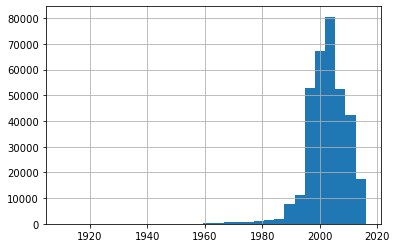

In [80]:
data['registration_year'].hist(bins=30);

Попробуем посмотреть по цене

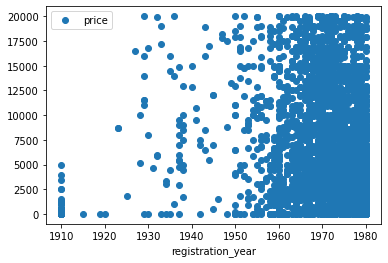

In [81]:
data[data['registration_year'] <= 1980].plot(
    x='registration_year', y='price', style='o');

In [82]:
data[data['registration_year'] == 1910].head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
15,450,small,1910,unknown,0,128.0,5000,0,petrol,10.0,no
6629,0,small,1910,unknown,0,228.0,5000,1,other,33.0,no
6977,135,unknown,1910,unknown,0,228.0,5000,0,unknown,24.0,no
10183,1250,unknown,1910,unknown,0,166.0,5000,0,unknown,1.0,no
18023,1,unknown,1910,unknown,0,228.0,5000,0,unknown,38.0,no
23750,3900,wagon,1910,manual,90,170.0,150000,0,petrol,38.0,no
24458,50,small,1910,manual,0,228.0,5000,1,unknown,38.0,yes
26579,0,unknown,1910,unknown,0,228.0,150000,0,unknown,0.0,no
29383,0,unknown,1910,unknown,0,228.0,5000,1,unknown,33.0,no
29516,80,small,1910,unknown,0,176.0,150000,0,unknown,9.0,no


In [83]:
data[data['registration_year'] == 1950].head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
60844,160,sedan,1950,manual,0,166.0,150000,2,petrol,20.0,no
74705,3900,other,1950,auto,180,166.0,150000,5,petrol,20.0,no
77819,1,coupe,1950,manual,0,166.0,100000,1,petrol,26.0,no
83020,20000,sedan,1950,manual,0,228.0,5000,3,petrol,33.0,no
103192,10000,coupe,1950,manual,130,166.0,5000,1,petrol,0.0,no
174755,17900,coupe,1950,manual,110,228.0,100000,1,petrol,33.0,no
204589,0,bus,1950,unknown,0,224.0,5000,11,petrol,38.0,no
207313,1,coupe,1950,manual,0,25.0,100000,5,petrol,26.0,no
216233,6500,other,1950,manual,0,228.0,5000,12,other,33.0,no
217944,900,small,1950,manual,0,228.0,150000,1,petrol,24.0,no


Пробуем аккуратно срезать выбросы. Уберем нулевую мощность и цены ниже 300 долларов.

In [84]:
data = data[
    (data['price'] > 300) &
    (data['power'] != 0)
]

In [85]:
data['registration_year'].sort_values().unique()

array([1910, 1923, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1935, 1936,
       1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1947, 1948, 1949,
       1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016], dtype=int64)

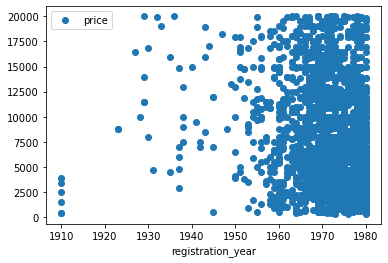

In [86]:
data[data['registration_year'] <= 1980].plot(
    x='registration_year', y='price', style='o');

In [87]:
data[data['registration_year'] == 1980].head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
1208,7900,sedan,1980,auto,194,95.0,125000,9,petrol,20.0,no
1249,5500,sedan,1980,manual,96,166.0,60000,1,petrol,10.0,no
2512,11111,coupe,1980,auto,136,228.0,100000,7,petrol,10.0,no
3209,500,unknown,1980,manual,44,130.0,5000,12,petrol,38.0,no
4539,15000,convertible,1980,manual,67,228.0,150000,7,petrol,33.0,no
4920,1300,unknown,1980,unknown,110,228.0,150000,0,unknown,24.0,no
5770,10000,unknown,1980,manual,26,16.0,40000,0,unknown,37.0,no
7180,12500,coupe,1980,auto,136,95.0,150000,9,petrol,20.0,no
7985,4800,unknown,1980,unknown,50,224.0,150000,3,unknown,38.0,no
10833,17900,convertible,1980,auto,245,166.0,150000,5,petrol,20.0,no


In [88]:
data[data['registration_year'] == 1960].head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
16902,19000,suv,1960,manual,22,228.0,60000,4,petrol,33.0,no
17806,17900,suv,1960,manual,30,166.0,60000,7,gasoline,20.0,no
19106,1500,small,1960,manual,21,166.0,5000,1,petrol,27.0,yes
22607,9900,sedan,1960,manual,60,166.0,50000,1,petrol,39.0,no
23059,16900,convertible,1960,manual,44,228.0,5000,7,petrol,33.0,no
50229,2000,sedan,1960,manual,30,130.0,150000,6,petrol,38.0,no
58906,9900,coupe,1960,manual,50,228.0,70000,7,petrol,33.0,no
61316,2460,sedan,1960,manual,60,228.0,60000,3,petrol,33.0,no
70316,11300,other,1960,manual,60,166.0,125000,7,petrol,39.0,no
77582,14990,suv,1960,manual,69,202.0,5000,1,petrol,18.0,no


In [89]:
data[data['registration_year'] == 1950].head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
74705,3900,other,1950,auto,180,166.0,150000,5,petrol,20.0,no
103192,10000,coupe,1950,manual,130,166.0,5000,1,petrol,0.0,no
174755,17900,coupe,1950,manual,110,228.0,100000,1,petrol,33.0,no
261663,6500,sedan,1950,manual,54,166.0,100000,3,petrol,24.0,no
291064,12950,suv,1950,manual,45,166.0,5000,0,gasoline,14.0,no
319809,4100,sedan,1950,manual,37,166.0,100000,7,petrol,24.0,no


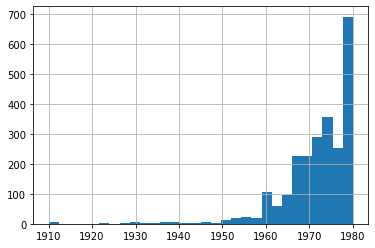

In [90]:
data[
    data['registration_year'] <= 1980
    ]['registration_year'].hist(bins=30);

In [91]:
data[data['registration_year'] <= 1980]['power'].describe()

count     2433.000000
mean       109.343198
std        334.350100
min          1.000000
25%         50.000000
50%         76.000000
75%        136.000000
max      16051.000000
Name: power, dtype: float64

Минимальное значение 1...

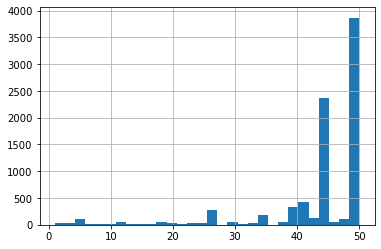

In [92]:
data[data['power'] <= 50]['power'].hist(bins=30);

Срежем мощность меньше 40 и год меньше 1960.

In [93]:
data = data[
    (data['registration_year'] >= 1960) &
    (data['power'] > 39)
]

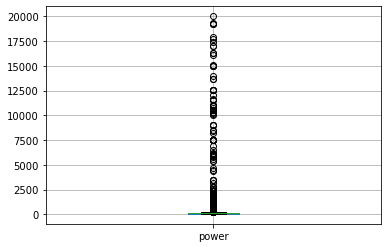

In [94]:
data.boxplot(column='power');

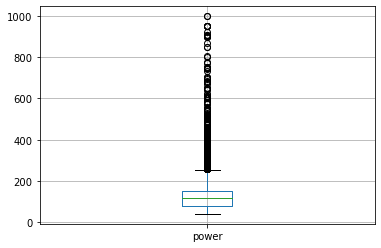

In [95]:
data[data['power'] < 1000].boxplot(column='power');

Допустим посмотрим мощность более 300.

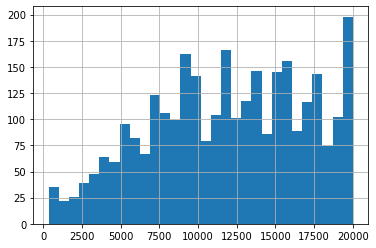

In [96]:
data[
    (data['power'] > 300) & (data['power'] < 1000)
    ]['price'].hist(bins=30);

Значений очень мало. Вдаваться в изучение по марке ради нескольких значений при огромной выборке не стоит. Ограничим разумным выбором в мощность 400 л.с.

In [97]:
data = data[
    (data['power'] <= 400)
]

In [98]:
print(f'Процент от изначальной выборки: \n')
print(len(data) / len(data_origin) * 100, ' %')
print('Длина выборки: ', data.shape[0])

Процент от изначальной выборки: 

80.49265031647802  %
Длина выборки:  285241


**Вывод**

Убрали аномалии в годе регистрации, цене и мощности:

* мощность от 40 до 400
* цена не ниже 300 долларов
* год от 1960 по 2016

Урезанная выборка составляет 80.49 %  от всех данных. Всего длина выборки: 285241.

#### Выборки

Взглягем на корреляюцию данных.

In [99]:
data.corr()

,price,registration_year,power,model,kilometer,registration_month,brand
price,1.000000,0.501898,0.501271,-0.027063,-0.396783,0.058060,-0.103676
registration_year,0.501898,1.000000,0.110093,-0.031792,-0.326677,0.038398,-0.016355
power,0.501271,0.110093,1.000000,-0.125035,0.108576,0.032411,-0.329569
model,-0.027063,-0.031792,-0.125035,1.000000,-0.034993,-0.019118,0.451789
kilometer,-0.396783,-0.326677,0.108576,-0.034993,1.000000,-0.014208,-0.052034
registration_month,0.058060,0.038398,0.032411,-0.019118,-0.014208,1.000000,-0.008626
brand,-0.103676,-0.016355,-0.329569,0.451789,-0.052034,-0.008626,1.000000


ККП - коэффициент корреляции Пирсона.

* Чем свежее машина по годам, тем выше цена:
    * КПП - 0.501;
* Чем больше л.с. у машины, тем выше цена:
    * КПП - 0.501
* Чем больше пробег, тем ниже цена, зависимость слабая:
    * КПП - -0.396
* Нет корреляции Пирсона у цены и у месяца регистрации авто.

Столбец `registration_month` можно будет удалить для различных проб обучения моделей.

Посмотрим на признаки через коэффициент корреляции Phik.

In [100]:
data.phik_matrix().round(2)

interval columns not set, guessing: ['price', 'registration_year', 'power', 'model', 'kilometer', 'registration_month', 'brand']


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
price,1.00,0.26,0.66,0.28,0.50,0.21,0.32,0.10,0.25,0.30,0.26
vehicle_type,0.26,1.00,0.29,0.37,0.49,0.43,0.26,0.12,0.39,0.37,0.04
registration_year,0.66,0.29,1.00,0.11,0.24,0.21,0.41,0.10,0.26,0.22,0.12
gearbox,0.28,0.37,0.11,1.00,0.47,0.14,0.05,0.10,0.21,0.37,0.01
power,0.50,0.49,0.24,0.47,1.00,0.40,0.11,0.05,0.24,0.52,0.03
model,0.21,0.43,0.21,0.14,0.40,1.00,0.11,0.05,0.17,0.78,0.04
kilometer,0.32,0.26,0.41,0.05,0.11,0.11,1.00,0.05,0.15,0.16,0.08
registration_month,0.10,0.12,0.10,0.10,0.05,0.05,0.05,1.00,0.11,0.05,0.04
fuel_type,0.25,0.39,0.26,0.21,0.24,0.17,0.15,0.11,1.00,0.14,0.05
brand,0.30,0.37,0.22,0.37,0.52,0.78,0.16,0.05,0.14,1.00,0.04


Выведем красиво.

interval columns not set, guessing: ['price', 'registration_year', 'power', 'model', 'kilometer', 'registration_month', 'brand']


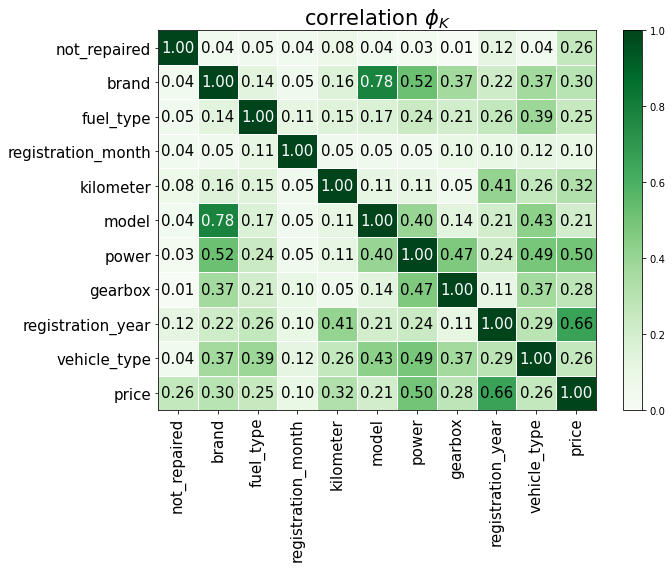

In [101]:
phik_overview = data.phik_matrix().round(2)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()

1. Целевой признак у нас `price`. Признаки по убыванию, коррелирующие на цену в наибольшей степени **Phik > 0.5**:
    * registration_year
    * model
    * power
2. Признаки по убыванию, коррелирующие на цену в наименьшей степени **Phik < 0.5**:
    * brand
    * kilometer
    * gearbox
    * not_repaired
    * vehicle_type
    * fuel_type
    * registration_month
3. registration_month имеет опять наименьшую корреляцию.

Сделаем следующие выборки:

* Очищенный датасет.
* Ради эксперимента уберем признак `registration_month`, поскольку имеет малую корреляцию с целевым признаком.


Сделаем обучающие выборки и конечную тестовую. В тестовой выборке данные не будут изменены никоим образом.

Тестовая выборка:

    * с аномалиями и `unknown`, поскольку при реальных данных с такой выгрузкой мы не имеем право отказываться от каких-либо предсказаний объектов.

In [102]:
# Словарь для наших выборок
data_dict = {}

data_down_train, data_down_test = train_test_split(
    data, test_size=.25, random_state=13)

# Первая выборка без аномалий с заполнением `unknown`
data_dict['data_down'] = data_down_train, data_down_test

In [103]:
# Проверка
data_dict['data_down'][1].shape

(71311, 11)

In [104]:
data.isna().mean()

price                 0.0
vehicle_type          0.0
registration_year     0.0
gearbox               0.0
power                 0.0
model                 0.0
kilometer             0.0
registration_month    0.0
fuel_type             0.0
brand                 0.0
not_repaired          0.0
dtype: float64

In [105]:
data.drop(columns='registration_month').columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'not_repaired'],
      dtype='object')

In [106]:
# Выбираем наши признаки без 'registration_month'
data_down_cut = data.drop(columns='registration_month')

data_down_cut_train, data_down_cut_test = train_test_split(
    data_down_cut, test_size=.25, random_state=13)

# Вторая выборка: убрали аномалиии с заполнением `unknown`
# и без 'registration_month'
data_dict['data_down_cut'] = data_down_cut_train, data_down_cut_test

In [107]:
# Проверка
print([col for col, v in data_dict.items()])

['data_down', 'data_down_cut']


Создали словарь `data_dict` из 2-х выборок для поиска лучшей модели предсказаний:

    * 'data_down'
    * 'data_down_cut'

В выборках у нас урезанные данные. То есть для финального тестирования, где нужно учесть, что в применении в реальности выбранной конечной модели, данные будут не урезаны. То есть они будут поступать со значениями NaN и аномалиями и такие данные нужно будет предсказывть.

Поэтому сохраним в словарь такие проверочные выборки для наших будущих моделей, где данные не урежутся, пропуски будут заполнены.

In [108]:
# Сделаем тестовые выборки не урезанными, заполненными
print('До: ', len(data_dict['data_down'][1]), '\n')
print('До: ', len(data_dict['data_down_cut'][1]), '\n')

data_anomaly_train, data_anomaly_test = train_test_split(
    data_anomaly, test_size=.25, random_state=13)

data_dict['data_down'] = data_down_train, data_anomaly_test


# не забываем убрать 'registration_month' для выборки 'data_down_cut'
data_anomaly_test = data_anomaly_test.drop(columns='registration_month')

data_dict['data_down_cut'] = data_down_cut_train, data_anomaly_test

print('После: ', len(data_dict['data_down'][1]), '\n')
print('После: ', len(data_dict['data_down_cut'][1]))

# Проверка

До:  71311 

До:  71311 

После:  88593 

После:  88593


In [109]:
data_down_cut.describe()


,price,registration_year,power,model,kilometer,brand
count,285241.000000,285241.000000,285241.000000,285241.000000,285241.000000,285241.000000
mean,5004.963838,2003.046378,121.976006,111.947374,128220.750173,20.635473
std,4599.031871,6.275350,52.332305,73.348829,36598.361262,13.417234
min,301.000000,1960.000000,40.000000,0.000000,5000.000000,0.000000
25%,1499.000000,1999.000000,80.000000,42.000000,125000.000000,9.000000
50%,3350.000000,2003.000000,115.000000,116.000000,150000.000000,23.000000
75%,7200.000000,2007.000000,150.000000,170.000000,150000.000000,33.000000
max,20000.000000,2016.000000,400.000000,250.000000,150000.000000,39.000000


#### Вывод по подготовке выборок

0. Убрали аномалии в годе регистрации, цене и мощности:

    * мощность от 25 до 450
    * цена не ниже 200 долларов
    * год от 1950 по 2016

    * Урезанная выборка составляет 82.04 %  от всех данных. Всего длина выборки: 290725.


0. Провели стат. анализ признаков по КПП (коэффициент корреляции Пирсона) к признаку `price`, без аномалий:

    * Чем свежее машина по годам, тем выше цена:
        * КПП - 0.489;
    * Чем больше л.с. у машины, тем выше цена:
        * КПП - 0.505
    * Чем больше пробег, тем ниже цена, зависимость слабая:
        * КПП - -0.392
    * Нет корреляции Пирсона у цены и у месяца регистрации авто.


0. Провели стат. анализ через коэффициент корреляции Phik, без аномалий:

    * Целевой признак у нас `price`. Признаки по убыванию, коррелирующие на цену в наибольшей степени **Phik > 0.5**:
        * registration_year
        * model
        * power
    * Признаки по убыванию, коррелирующие на цену в наименьшей степени **Phik < 0.5**:
        * brand
        * kilometer
        * gearbox
        * not_repaired
        * vehicle_type
        * fuel_type
        * registration_month
    * registration_month имеет опять наименьшую корреляцию.


0.  Сделали следующие выборки:

    * Очищенный датасет.
    * Ради эксперимента уберем признак `registration_month`, поскольку имеет малую корреляцию с целевым признаком.


0.  Создали словарь для различных выборок, на которых будем искать лучшие метрики качества и поиск лучшей модели:

    * Сделали обучающие выборки и конечную тестовую. В тестовой выборке данные не будут изменены никоим образом:
    
        * с аномалиями и `unknown`, поскольку при реальных данных с такой выгрузкой мы не имеем право отказываться от каких-либо предсказаний объектов.


0. Создали словарь `data_dict` из 2-х выборок для поиска лучшей модели предсказаний:

    * 'data_down'
    * 'data_down_cut'


0. Тестовые выборки не урезаны по длине, так как в реальности данные будут поступать со значениями NaN и аномалиями и такие данные нужно будет предсказывть.

## Обучение моделей

In [110]:
pd.options.mode.chained_assignment = None

In [111]:
# Наши ключи к выборкам
data_dict.keys()

dict_keys(['data_down', 'data_down_cut'])

In [112]:
# Проверка урезана ли нужная выборка
data_dict['data_down_cut'][1].columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'not_repaired'],
      dtype='object')

Проделаем для начала все вручную для проверки работы.

In [113]:
X_train = data_dict['data_down'][0].drop('price', axis=1)
y_train = data_dict['data_down'][0]['price']

In [114]:
y_constant = pd.Series(y_train.mean(), index=y_train.index)

constant = mean_squared_error(y_train, y_constant) ** 0.5
constant.round(2)

4599.48

Проверим предобработку данных последовательно.

In [115]:
X_train.head(3)

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
193712,wagon,2005,auto,272,15.0,150000,1,gasoline,2.0,no
269117,bus,2011,manual,109,47.0,80000,11,gasoline,20.0,no
86891,sedan,1998,auto,130,174.0,150000,4,petrol,23.0,no


Методом OHE подготовим признаки, где не так много уникальных значений.

Столбцы `model` и `brand` подготовим с помощью Ordinal Encoding, поскольку там очень много уникальных значений.

In [116]:
# ОНЕ без ['model', 'brand']
X_train = pd.get_dummies(
    X_train.drop(['model', 'brand'], axis=1), drop_first=True)

X_train.head(3)

,registration_year,power,kilometer,registration_month,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,gearbox_manual,gearbox_unknown,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,fuel_type_unknown,not_repaired_yes
193712,2005,272,150000,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
269117,2011,109,80000,11,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
86891,1998,130,150000,4,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [117]:
# Добавляем обратно ['model', 'brand']
X_train[['model', 'brand']] = (
    data_dict['data_down'][0][['model', 'brand']]
    )
X_train.head(3)

,registration_year,power,kilometer,registration_month,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,fuel_type_unknown,not_repaired_yes,model,brand
193712,2005,272,150000,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,15.0,2.0
269117,2011,109,80000,11,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,47.0,20.0
86891,1998,130,150000,4,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,174.0,23.0


Под конец масштабирование.

In [118]:
numeric = list(X_train.columns)

scaler = StandardScaler()
scaler.fit(X_train[numeric])

X_train[numeric] = scaler.transform(X_train[numeric])

X_train.head(3)

,registration_year,power,kilometer,registration_month,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,fuel_type_unknown,not_repaired_yes,model,brand
193712,0.310706,2.863893,0.596214,-1.414866,-0.263659,-0.229037,-0.089765,-0.629466,-0.544134,-0.19891,...,-0.010141,1.507333,-0.026043,-0.128065,-0.013503,-1.298257,-0.224606,-0.310677,-1.323669,-1.392070
269117,1.264194,-0.247581,-1.312760,1.389454,-0.263659,-0.229037,-0.089765,-0.629466,-0.544134,-0.19891,...,-0.010141,1.507333,-0.026043,-0.128065,-0.013503,-1.298257,-0.224606,-0.310677,-0.887356,-0.050542
86891,-0.801696,0.153283,0.596214,-0.573570,-0.263659,-0.229037,-0.089765,1.588648,-0.544134,-0.19891,...,-0.010141,-0.663424,-0.026043,-0.128065,-0.013503,0.770264,-0.224606,-0.310677,0.844260,0.173046


### Функции

После проверки создадим функции.

In [119]:
# MSE и RMSE константной модели
def y_constant(y_train):

    global constant

    y_constant = pd.Series(y_train.mean(), index=y_train.index)
    constant = mean_squared_error(y_train, y_constant) 
    return (constant ** 0.5).round(2)

In [120]:
# Предобработка данных
def preprocessing(data_dict, key):

    # Получение train и test по позиционным аргументам
    X_train = data_dict[key][0].drop('price', axis=1)
    y_train = data_dict[key][0]['price']

    X_test = data_dict[key][1].drop('price', axis=1)
    y_test = data_dict[key][1]['price']


    # OHE кодирование категориальных признаков
    # Поскольку в этих признаках мало вариативности, здесь 
    # можно по отдельности применить, в отличии от ['model', 'brand']
    X_train = pd.get_dummies(
        X_train.drop(['model', 'brand'], axis=1), drop_first=True)
        
    X_test = pd.get_dummies(
        X_test.drop(['model', 'brand'], axis=1), drop_first=True)

    X_train[['model', 'brand']] = data_dict[key][0][['model', 'brand']]
    X_test[['model', 'brand']] = data_dict[key][1][['model', 'brand']]


    #encoder = OrdinalEncoder()

    #X_train.loc[:, ['model', 'brand']] = encoder.fit_transform(
    #    X_train[['model', 'brand']])
    
    #X_test.loc[:, ['model', 'brand']] = encoder.fit_transform(
    #    X_test[['model', 'brand']])

    # Применение StandardScaler для масштабирования
    numeric = list(X_train.columns)
    scaler = StandardScaler()
    scaler.fit(X_train[numeric])
    X_train[numeric] = scaler.transform(X_train[numeric])
    X_test[numeric] = scaler.transform(X_test[numeric])

    return X_train, y_train, X_test, y_test

Проверим работоспособность.

In [121]:
data_dict.keys()

dict_keys(['data_down', 'data_down_cut'])

In [122]:
%%time

# Создадим список ключей для нашего словаря с выборками
key = ['data_down', 'data_down_cut']

X_train, y_train, X_test, y_test = preprocessing(
    data_dict, 
    key[1])

CPU times: total: 391 ms
Wall time: 399 ms


In [123]:
y_constant(y_train)

4599.48

In [124]:
constant

21155232.07793134

In [125]:
display(X_train.shape)
display(y_train.shape)
display(X_test.shape)
display(y_test.shape)

(213930, 23)

(213930,)

(88593, 23)

(88593,)

In [126]:
# датасет для финального сравнения, куда будем записывать скоры
# всех наших моделей на всех выборках
scores = pd.DataFrame(
    columns=['RMSE train', 'RMSE test', 'constant RMSE'])

In [127]:
# Ключи
key

['data_down', 'data_down_cut']

### RandomForestRegressor

In [128]:
# функция для RandomForestRegressor

def rfr_model(data_dict, key):

    # используем для индексирования датасета финального сравнения
    name = 'RandomForestRegressor'

    # Предобработка данных
    X_train, y_train, X_test, y_test = preprocessing(
        data_dict, 
        key)

    # RMSE константной модели для сравнения эффективности модели
    rmse_const = y_constant(y_test)

    # начало самого цикла перебора параметров для модели
    best_rfr = None
    best_result_rfr = constant * (-1)
    best_depth = 0
    best_estimator = 0
    row_rfr = []

    for depth in tqdm(range(15, 28, 6)):
        for est in tqdm(range(80, 141, 30)):
                
            rfr = RandomForestRegressor(
                random_state=13, n_estimators=est, max_depth=depth)
            cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=13)
            scores_rfr = cross_val_score(
                rfr, X_train, y_train, cv=cv, 
                scoring='neg_mean_squared_error', 
                error_score='raise', n_jobs=-1)
            result = pd.Series(scores_rfr).mean()
            row_rfr.append(result)
            if result > best_result_rfr:
                best_rfr = rfr
                best_result_rfr = result
                best_depth = depth
                best_estimator = est

    # Дополнительно дублируем, чтобы простейшим способом 
    # понять на графике скоры в циклах модели
    best_rfr.fit(X_train, y_train)


    # Вывод всех результатов     
    print('\n')
    print("Random Forest Regressor ", key, '\n')   
    plt.plot(row_rfr);
    plt.title('MSE')
    plt.show()

    rmse_train = mean_squared_error(
        y_train, best_rfr.predict(X_train)) ** 0.5

    rmse_test = mean_squared_error(
        y_test, best_rfr.predict(X_test)) ** 0.5

    print('\n')
    print("Лучший score на кросс валидации: ", (best_result_rfr * (-1)))
    print("depth =", best_depth, ": ", '\n')
    print("est =", best_estimator, ": ", '\n')
    print("Итоговое RMSE train = ", rmse_train, '\n')
    print("constant RMSE test= ", rmse_const, '\n')
    print("Итоговое RMSE test = ", rmse_test, '\n')


    # запись в финальный датасет скоров
    scores.loc[(
        key + ' + ' + name
        ), 'RMSE train'] = rmse_train.round(2)
    scores.loc[(
        key + ' + ' + name
        ), 'RMSE test'] = rmse_test.round(2)
    scores.loc[(
        key + ' + ' + name
        ), 'constant RMSE'] = rmse_const


  0%|          | 0/2 [00:00<?, ?it/s]



100%|██████████| 3/3 [12:19<00:00, 246.54s/it]




100%|██████████| 3/3 [13:19<00:00, 266.41s/it]




100%|██████████| 3/3 [38:23<00:00, 767.72s/it]




Random Forest Regressor  data_down 



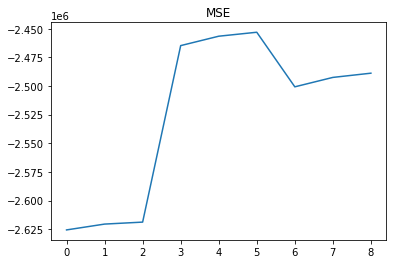

 50%|█████     | 1/2 [40:10<40:10, 2410.23s/it]



Лучший score на кросс валидации:  2453116.5354460087
depth = 21 :  

est = 140 :  

Итоговое RMSE train =  857.0531776845875 

constant RMSE test=  4518.19 

Итоговое RMSE test =  1618.1114978549078 







100%|██████████| 3/3 [09:37<00:00, 192.42s/it]




100%|██████████| 3/3 [10:09<00:00, 203.30s/it]




100%|██████████| 3/3 [30:24<00:00, 608.28s/it]




Random Forest Regressor  data_down_cut 



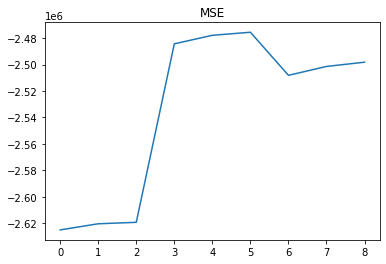

100%|██████████| 2/2 [1:12:15<00:00, 2167.82s/it]



Лучший score на кросс валидации:  2475522.062257834
depth = 21 :  

est = 140 :  

Итоговое RMSE train =  1017.2082310790166 

constant RMSE test=  4518.19 

Итоговое RMSE test =  1673.402327012258 

CPU times: total: 4min 38s
Wall time: 1h 12min 15s


In [129]:
%%time

# цикл для модели по всем выборкам
for item in tqdm(key):
    rfr_model(data_dict, item)

### LightGBM

In [130]:
# Функция для модели LightGBM
def lgb_model(data_dict, key):
    
    # используем для индексирования датасета финального сравнения
    name = 'LightGBM'

    # Предобработка данных
    X_train, y_train, X_test, y_test = preprocessing(
        data_dict, 
        key)

    # RMSE константной модели для сравнения эффективности модели
    rmse_const = y_constant(y_test)

    # начало самого цикла перебора параметров для модели
    best_lgb = None
    best_result_lgb = constant
    best_iter = 0
    best_nleaves = 0
    best_depth = 0
    row_lgb = []

    for depth in tqdm(range(11, 21, 3)):
        for leave in tqdm(range(12, 33, 5)):

            lgb_train = lgb.Dataset(X_train, y_train)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': 'mse',
                'max_depth': depth,
                'num_leaves': leave,
                'learning_rate': 0.4,
                'feature_fraction': 0.9,
                'bagging_fraction': 0.8,
                'bagging_freq': 5,
                'verbose': -1,
                'force_col_wise': True,
                'random_seed': 13,
                'device': 'cpu'
            }

            callbacks = [
                lgb.early_stopping(stopping_rounds=200, verbose=0),
                lgb.log_evaluation(period=0)]

            gbm = lgb.cv(params,
                lgb_train,
                num_boost_round=1000,
                metrics='mse',
                return_cvbooster=True,
                callbacks=callbacks,
                stratified = False
                )
            
            result = gbm['l2-mean'][
                    (gbm['cvbooster'].best_iteration - 1)]

            row_lgb.append(result)

            if result < best_result_lgb:
                best_lgb = gbm['cvbooster']
                best_result_lgb = result
                best_iter = gbm['cvbooster'].best_iteration
                best_nleaves = leave
                best_depth = depth

        row_lgb.append(result)


    # Вывод всех результатов
    print('\n')
    print("LightGBM ", key, '\n')   
    plt.plot(row_lgb);
    plt.title('MSE')
    plt.show()

    y_pred_train = best_lgb.predict(
        X_train, num_iteration=best_lgb.best_iteration)

    y_pred_test = best_lgb.predict(
        X_test, num_iteration=best_lgb.best_iteration)

    rmse_train = mean_squared_error(
        y_train, np.mean(y_pred_train, axis=0)) ** 0.5
        
    rmse_test = mean_squared_error(
        y_test, np.mean(y_pred_test, axis=0)) ** 0.5

    print('\n')
    print("Лучший score на кросс валидации: ", (best_result_lgb), '\n')
    print(f'Best iter: {best_iter}', '\n')
    print("best_depth =", best_depth, '\n')
    print("num_leaves =", best_nleaves, '\n')
    print("Итоговое RMSE train = ", rmse_train, '\n')
    print("constant RMSE test = ", rmse_const, '\n')
    print("Итоговое RMSE test = ", rmse_test, '\n')


    # запись в финальный датасет скоров
    scores.loc[(
        key + ' + ' + name
        ), 'RMSE train'] = rmse_train.round(2)
    scores.loc[(
        key + ' + ' + name
        ), 'RMSE test'] = rmse_test.round(2)
    scores.loc[(
        key + ' + ' + name
        ), 'constant RMSE'] = rmse_const

  0%|          | 0/2 [00:00<?, ?it/s]





100%|██████████| 5/5 [01:19<00:00, 15.84s/it]






100%|██████████| 5/5 [01:16<00:00, 15.20s/it]






100%|██████████| 5/5 [01:19<00:00, 15.88s/it]






100%|██████████| 4/4 [05:12<00:00, 78.18s/it]



LightGBM  data_down 



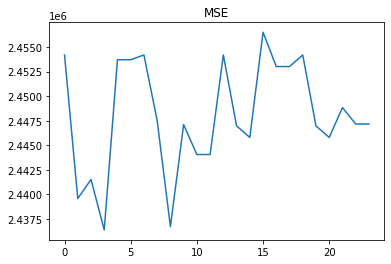

 50%|█████     | 1/2 [05:29<05:29, 329.42s/it]



Лучший score на кросс валидации:  2436390.613678393 

Best iter: 865 

best_depth = 11 

num_leaves = 27 

Итоговое RMSE train =  1221.5694268441682 

constant RMSE test =  4518.19 

Итоговое RMSE test =  1663.0939714047447 









100%|██████████| 5/5 [01:25<00:00, 17.11s/it]






100%|██████████| 5/5 [01:25<00:00, 17.10s/it]






100%|██████████| 5/5 [01:37<00:00, 19.42s/it]






100%|██████████| 4/4 [06:08<00:00, 92.16s/it]



LightGBM  data_down_cut 



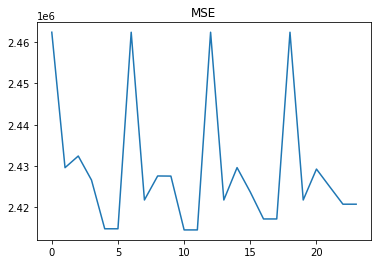

100%|██████████| 2/2 [11:49<00:00, 354.86s/it]



Лучший score на кросс валидации:  2414572.357507149 

Best iter: 783 

best_depth = 14 

num_leaves = 32 

Итоговое RMSE train =  1256.9308187430925 

constant RMSE test =  4518.19 

Итоговое RMSE test =  1681.959493211539 

CPU times: total: 2h 15min 48s
Wall time: 11min 49s


In [131]:
%%time

for item in tqdm(key):
    lgb_model(data_dict, item)

### CatBoost

In [132]:
# функция для CatBoost
def cat_model(data_dict, key):

    # используем для индексирования датасета финального сравнения
    name = 'CatBoost'

    # Предобработка данных
    X_train, y_train, X_test, y_test = preprocessing(
        data_dict, 
        key)

    # RMSE константной модели для сравнения эффективности модели
    rmse_const = y_constant(y_test)

    # начало самой модели

    # Поскольку здесь немного проще, то для сравнения с остальными 
    # моделями удалось подобрать не перебирая через циклы
    # определенные гиперпараметры. 
    # Основная цель проекта – LightGBM
    cat_train = Pool(data=X_train, label=y_train)
    cat_test = Pool(data=X_test, label=y_test)

    params = {'eval_metric': 'RMSE',
            'loss_function': 'RMSE',
            'learning_rate': 0.1,
            'random_seed': 13,
            'depth': 14,
            'verbose':False}

    cv_data = cv(
            params = params,
            pool = cat_train,
            fold_count=5,
            shuffle=False,
            partition_random_seed=13,
            stratified=False,
            verbose=False,
            iterations = 1500,
            early_stopping_rounds=200
            )

    n_iter = np.argmin(cv_data['test-RMSE-mean'])

    cat = CatBoostRegressor(**params, iterations=n_iter)
    cat.fit(cat_train)

    # Вывод всех результатов 

    print('\n')
    print("Cat Boost Regressor ", key, '\n')   

    best_result_cat = cv_data.loc[
        n_iter, 'train-RMSE-mean'].round(2)

    rmse_train = mean_squared_error(y_train, cat.predict(cat_train)) ** 0.5
    rmse_test = mean_squared_error(y_test, cat.predict(cat_test)) ** 0.5

    lrate = params['learning_rate']
    depth = params['depth']

    print("Лучший score на кросс валидации: ", (best_result_cat), '\n')
    print(f'Best iter: {n_iter}', '\n')
    print("learning_rate =", lrate, '\n')
    print("depth =", depth, '\n')
    print("Итоговое RMSE train = ", rmse_train, '\n')
    print("constant RMSE test = ", rmse_const, '\n')
    print("Итоговое RMSE test = ", rmse_test, '\n \n')


    # запись в финальный датасет скоров
    scores.loc[(
        key + ' + ' + name
        ), 'RMSE train'] = rmse_train.round(2)
    scores.loc[(
        key + ' + ' + name
        ), 'RMSE test'] = rmse_test.round(2)
    scores.loc[(
        key + ' + ' + name
        ), 'constant RMSE'] = rmse_const


<div class="alert alert-success">
<b>Комментарий ревьюера:</b> ✔️Хорошо, что используешь кросс-валидацию!Молодец</div>

In [133]:
%%time

for item in tqdm(key):
    cat_model(data_dict, item)

  0%|          | 0/2 [00:00<?, ?it/s]

Training on fold [0/5]

bestTest = 1531.249743
bestIteration = 947

Training on fold [1/5]

bestTest = 1495.536126
bestIteration = 850

Training on fold [2/5]

bestTest = 1523.553712
bestIteration = 850

Training on fold [3/5]

bestTest = 1508.868061
bestIteration = 923

Training on fold [4/5]

bestTest = 1506.176949
bestIteration = 1198



Cat Boost Regressor  data_down 



 50%|█████     | 1/2 [22:53<22:53, 1373.68s/it]

Лучший score на кросс валидации:  1012.52 

Best iter: 977 

learning_rate = 0.1 

depth = 14 

Итоговое RMSE train =  1052.77410709957 

constant RMSE test =  4518.19 

Итоговое RMSE test =  1587.7450459229863 
 

Training on fold [0/5]

bestTest = 1530.552372
bestIteration = 881

Training on fold [1/5]

bestTest = 1493.494148
bestIteration = 901

Training on fold [2/5]

bestTest = 1513.472459
bestIteration = 1270

Training on fold [3/5]

bestTest = 1506.667143
bestIteration = 1113

Training on fold [4/5]

bestTest = 1509.197333
bestIteration = 1308



Cat Boost Regressor  data_down_cut 



100%|██████████| 2/2 [48:34<00:00, 1457.20s/it]

Лучший score на кросс валидации:  1121.39 

Best iter: 1067 

learning_rate = 0.1 

depth = 14 

Итоговое RMSE train =  1148.572892441824 

constant RMSE test =  4518.19 

Итоговое RMSE test =  1628.5133207377257 
 

CPU times: total: 3h 12min 39s
Wall time: 48min 34s


### Итог

Определили оптимальные гиперпараметры для моделей с лучшими RMSE и выборкой data_down:

* RandomForestRegressor:

    * max_depth = 21
    * n_estimators = 140

* LightGBM:

    * best_iteration = 865
    * max_depth = 11
    * num_leaves = 27

* CatBoost

    * iterations = 977 
    * learning_rate = 0.1
    * depth = 14

## Анализ работы моделей

In [134]:
scores

,RMSE train,RMSE test,constant RMSE
data_down + RandomForestRegressor,857.05,1618.11,4518.19
data_down_cut + RandomForestRegressor,1017.21,1673.4,4518.19
data_down + LightGBM,1221.57,1663.09,4518.19
data_down_cut + LightGBM,1256.93,1681.96,4518.19
data_down + CatBoost,1052.77,1587.75,4518.19
data_down_cut + CatBoost,1148.57,1628.51,4518.19


### Качество предсказания

По получившимся результатам RMSE test мы видим:

* Лучший результат RMSE на тесте `data_down`: 

    0. CatBoost – 1587.75
    0. RandomForestRegressor – 1618.11
    0. LightGBM – 1663.09


* CatBoost и LightGBM имеют более перспективные возможности по "тюнингу" параметров для улучшения качества предсказаний, в отличие от RandomForestRegressor.

* Удаление малозначимых признаков оказалось не эффективным.

### Время обучения

In [136]:
X_train, y_train, X_test, y_test = preprocessing(
    data_dict, 
    key[0])

In [137]:
X_train.shape

(213930, 24)

#### RandomForestRegressor

In [138]:
%%time

rfr = RandomForestRegressor(
    random_state=13, n_estimators=140, max_depth=21)

rfr.fit(X_train, y_train)

CPU times: total: 1min 55s
Wall time: 1min 55s


RandomForestRegressor(max_depth=21, n_estimators=140, random_state=13)

#### LightGBM

In [139]:
%%time

lgb_train = lgb.Dataset(X_train, y_train)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',
    'max_depth': 11,
    'num_leaves': 27,
    'learning_rate': 0.4,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'force_col_wise': True,
    'random_seed': 13,
    'device': 'cpu'
}

callbacks = [
    lgb.early_stopping(stopping_rounds=200, verbose=0),
    lgb.log_evaluation(period=0)]

gbm = lgb.cv(params,
    lgb_train,
    num_boost_round=1000,
    metrics='mse',
    return_cvbooster=True,
    callbacks=callbacks,
    stratified = False
    )

CPU times: total: 3min 41s
Wall time: 22.4 s


#### CatBoost

In [140]:
%%time

cat_train = Pool(data=X_train, label=y_train)
cat_test = Pool(data=X_test, label=y_test)

params = {'eval_metric': 'RMSE',
        'loss_function': 'RMSE',
        'learning_rate': 0.1,
        'random_seed': 13,
        'depth': 14,
        'verbose':False}

cat = CatBoostRegressor(**params, iterations=977)
cat.fit(cat_train)

CPU times: total: 14min 39s
Wall time: 4min 7s


#### Вывод

Время обучения моделей на одном из запусков ячеек:

* LightGBM: 22.4 s
* RandomForestRegressor: 1min 55s
* CatBoost: 4min 7s

* LightGBM оказался быстрей в обучении модели, чем CatBoost при текущем подборе параметров. При огромных датасетах возможно это будет играть свою роль для заказчика.

* `.shape` обучающей выборки (213930, 24).

### Скорость предсказания

In [141]:
X_test.shape

(88593, 24)

#### RandomForestRegressor

In [142]:
%%time

rfr.predict(X_test)

CPU times: total: 3.77 s
Wall time: 3.77 s


array([  833.80358146, 12370.03015873,   968.50683336, ...,
        6208.40930272,  1491.61603099,  2287.80595333])

#### LightGBM

In [143]:
%%time

np.mean(
    gbm['cvbooster'].predict(
    X_test, num_iteration=gbm['cvbooster'].best_iteration), axis=0)

CPU times: total: 36.8 s
Wall time: 3.75 s


array([ 800.94184418, 8152.85492612, 1265.65230844, ..., 5977.1243726 ,
       1750.36486862, 2314.25021123])

#### CatBoost

In [144]:
%%time

cat.predict(cat_test)

CPU times: total: 3.19 s
Wall time: 369 ms


array([ 863.92077518, 8821.48677785, 1243.64608241, ..., 6281.32160475,
       1676.19096332, 2295.65490984])

#### Вывод

Скорость предсказания моделей на одном из запусков ячеек:

* CatBoost: ~369 ms
* LightGBM: ~3.75 s
* RandomForestRegressor: ~3.77 s

* CatBoost практически мгновенно при размерности датасета (88593, 24).

## Вывод

### Вывод по подготовке данных

1. Привели названия столбцов из CamelCase в snake_case;
2. Обнаружили пропуски в столбцах:
    * VehicleType    0.105794
    * Gearbox        0.055967
    * Model          0.055606
    * FuelType       0.092827
    * NotRepaired    0.200791
3. Пропуски заполнили значением `unknown`, поскольку определить/заполнить по имеющимся данным/взаимосвязям не получилось;
4. В столбце NotRepaired заполнили пропуски значением `no`. Посчитав, что если клиент не указал, то значит не было ремонта;
5. Дубликатов не обнаружено;
6. Много аномалий по цене. Есть неадекватно низкие цены меньше 100 долларов. При просмотре зависимости от года регистрации авто выявились аномалии и в годах регистрации;
7. Есть аномалии в столбце Power: при мощности более 600 сил выводятся такие как матиз, пунто и т.д. при также неадекватно низкой цене;
8. В столбце Kilometer более 50% значений ровно 150000. Будем считать, что сервис просто ограничил пробег для заполнения.
9. В столбце RegistrationMonth аномалия: нулевой месяц регистрации. Число строк 37352;
10. Последние 4 столбца, никакой роли в построении модели играть не будут. Удалили. Также первый столбец — дата скачивания анкеты из базы.

**Вывод по подготовке выборок**

0. Убрали аномалии в годе регистрации, цене и мощности:

    * мощность от 40 до 400
    * цена не ниже 300 долларов
    * год от 1960 по 2016

    * Урезанная выборка составляет 80.49 %  от всех данных. Всего длина выборки: 285241.


0. Провели стат. анализ признаков по КПП (коэффициент корреляции Пирсона) к признаку `price`, без аномалий:

    * Чем свежее машина по годам, тем выше цена:
        * КПП - 0.501;
    * Чем больше л.с. у машины, тем выше цена:
        * КПП - 0.501
    * Чем больше пробег, тем ниже цена, зависимость слабая:
        * КПП - -0.396
    * Нет корреляции Пирсона у цены и у месяца регистрации авто.


0. Провели стат. анализ через коэффициент корреляции Phik, без аномалий:

    * Целевой признак у нас `price`. Признаки по убыванию, коррелирующие на цену в наибольшей степени **Phik > 0.5**:
        * registration_year
        * model
        * power
    * Признаки по убыванию, коррелирующие на цену в наименьшей степени **Phik < 0.5**:
        * brand
        * kilometer
        * gearbox
        * not_repaired
        * vehicle_type
        * fuel_type
        * registration_month
    * registration_month имеет опять наименьшую корреляцию.


0.  Сделали следующие выборки:

    * Очищенный датасет.
    * Ради эксперимента уберем признак `registration_month`, поскольку имеет малую корреляцию с целевым признаком.


0.  Создали словарь для различных выборок, на которых будем искать лучшие метрики качества и поиск лучшей модели:

    * Сделали обучающие выборки и конечную тестовую. В тестовой выборке данные не будут изменены никоим образом:
    
        * с аномалиями и `unknown`, поскольку при реальных данных с такой выгрузкой мы не имеем право отказываться от каких-либо предсказаний объектов.


0. Создали словарь `data_dict` из 2-х выборок для поиска лучшей модели предсказаний:

    * 'data_down'
    * 'data_down_cut'


0. Тестовые выборки не урезаны по длине, так как в реальности данные будут поступать со значениями NaN и аномалиями и такие данные нужно будет предсказывть.

### Вывод по обучению моделей

Определили оптимальные гиперпараметры для моделей с лучшими RMSE и выборкой data_down:

* RandomForestRegressor:

    * max_depth = 21
    * n_estimators = 140

* LightGBM:

    * best_iteration = 865
    * max_depth = 11
    * num_leaves = 27

* CatBoost

    * iterations = 977 
    * learning_rate = 0.1
    * depth = 14

### Вывод по анализу работы моделей

По получившимся результатам RMSE test мы видим:

* Лучший результат RMSE на тесте `data_down`: 

    0. CatBoost – 1587.75
    0. RandomForestRegressor – 1618.11
    0. LightGBM – 1663.09


* CatBoost и LightGBM имеют более перспективные возможности по "тюнингу" параметров для улучшения качества предсказаний, в отличие от RandomForestRegressor.

* Удаление малозначимых признаков оказалось не эффективным.

Время обучения моделей на одном из запусков ячеек:

* LightGBM: 22.4 s
* RandomForestRegressor: 1min 55s
* CatBoost: 4min 7s

* LightGBM оказался быстрей в обучении модели, чем CatBoost при текущем подборе параметров. При огромных датасетах возможно это будет играть свою роль для заказчика.

* `.shape` обучающей выборки (213930, 24).

#### Вывод

Скорость предсказания моделей на одном из запусков ячеек:

* CatBoost: ~369 ms
* LightGBM: ~3.75 s
* RandomForestRegressor: ~3.77 s

* CatBoost практически мгновенно при размерности датасета (88593, 24).

### Рекомендации

**Заказчику важны:**

- качество предсказания;
- скорость предсказания;
- время обучения.


**Качество предсказаний** лучше на датасете `data_down` без аномалий с заполнением пропусков с признаками:

    * ['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired']

* Лучший результат RMSE на тесте `data_down`: 

    0. CatBoost – 1587.75
    0. RandomForestRegressor – 1618.11
    0. LightGBM – 1663.09


**Время обучения моделей на одном из запусков ячеек:**

* LightGBM: 22.4 s
* RandomForestRegressor: 1min 55s
* CatBoost: 4min 7s

* LightGBM оказался быстрей в обучении модели, чем CatBoost при текущем подборе параметров. При огромных датасетах возможно это будет играть свою роль для заказчика.

* `.shape` обучающей выборки (218043, 24).

**Скорость предсказания моделей на одном из запусков ячеек:**

* CatBoost: ~369 ms
* LightGBM: ~3.75 s
* RandomForestRegressor: ~3.77 s

* CatBoost практически мгновенно при размерности датасета (88593, 24).